In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
def get_linreg_XY(df, exp_type):
    X = np.ones((len(df), 2), np.uint64)
    X[:, 1] = df.iloc[:, 0]
    
    exp_type_to_col = { "defence"  : "Def Exp Gained",
                        "hitpoint" : "HP Exp Gained" }
    col = exp_type_to_col[exp_type]
    Y = df[col].values
    
    return X, Y
    
def linear_regression(X, Y):  
    Xt = X.transpose()
    
    # compute beta = (X^t . X)^-1 . X^t . Y
    coefficients = ((np.linalg.inv(Xt.dot(X))).dot(Xt)).dot(Y)
    coefficients[0], coefficients[1] = coefficients[1], coefficients[0]
    
    return coefficients

def get_graph_df(df):
    exp_type = np.zeros(len(df))
    d1 = { "Time (min)" : df["Time (min)"],
           "Exp Gained" : df["Def Exp Gained"],
           "Exp Type"   : exp_type } # initialize exp type column
    defence_df = pd.DataFrame(data = d1)
    defence_df.iloc[:, 2] = "defence" # declare exp type column

    d2 = { "Time (min)" : df["Time (min)"],
           "Exp Gained" : df["HP Exp Gained"],
           "Exp Type"   : exp_type }
    hitpoint_df = pd.DataFrame(data = d2)
    hitpoint_df.iloc[:, 2] = "hitpoint"

    graph_df = defence_df.append(hitpoint_df)
    
    return graph_df

In [2]:
# load data
exp_df = pd.read_csv("data.csv")

In [3]:
# prepare data for linear regression
X_defence, Y_defence = get_linreg_XY(exp_df, "defence")
X_hitpoint, Y_hitpoint = get_linreg_XY(exp_df, "hitpoint")
X_stats_regress = exp_df.iloc[:, 0]

In [4]:
defence_coefficients = linear_regression(X_defence, Y_defence)
defence_stats_coefficients = stats.linregress(X_stats_regress, Y_defence)

print("Defence EXP")
print("Slope and x-intercept using matricies: ", defence_coefficients)
print("Slope and x-intercept using SciPy stats: ", defence_stats_coefficients[0:2])

hitpoint_coefficients = linear_regression(X_hitpoint, Y_hitpoint)
hitpoint_stats_coefficients = stats.linregress(X_stats_regress, Y_hitpoint)

print("\nHitpoint EXP")
print("Slope and x-intercept using matricies: ", hitpoint_coefficients)
print("Slope and x-intercept using SciPy stats: ", hitpoint_stats_coefficients[0:2])

Defence EXP
Slope and x-intercept using matricies:  [25.31087719 -3.87368421]
Slope and x-intercept using SciPy stats:  (25.310877192982453, -3.873684210526335)

Hitpoint EXP
Slope and x-intercept using matricies:  [ 8.41586667 -1.288     ]
Slope and x-intercept using SciPy stats:  (8.415866666666666, -1.2879999999998972)


In [17]:
# prepare data for visualization
graph_df = get_graph_df(exp_df)
    # write to csv

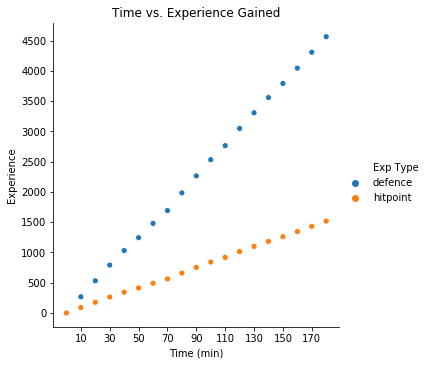

In [6]:
# visualize data
exp_scatter = sns.relplot(x = "Time (min)", y = "Exp Gained", hue = "Exp Type", data = graph_df)
exp_scatter.set(title = "Time vs. Experience Gained",
                       xlabel = "Time (min)",
                       xticks = graph_df.iloc[1:len(graph_df) // 2 :2, 0],
                       ylabel = "Experience",
                       yticks = range(0, 5000, 500))

plt.show()

In [18]:
# help(pd.DataFrame.to_csv)